In [6]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pandas as pd
import numpy as np
import scipy.optimize
import re
import os
import importlib

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter
from matplotlib import animation, rc
from IPython.display import HTML


import trmc.kin as kin
import trmc.load as load
import trmc.analysis as analysis
import trmc.plot as plot
from trmc.plot import exp_formatter

import xarray as xr

mpl.rcParams['figure.figsize'] = [8, 8]
mpl.rc('font',**{'size' : 18})

from IPython.display import clear_output

import itertools

In [7]:
def loadsweep(fp,defaultV = 0.025):
    df = pd.read_csv(fp,index_col=False)
    
    if 'Experimental R' in df.columns:
        df = pd.read_csv(fp,index_col=False)
        df = df.set_index(df['f(Ghz)'])
        s = df[' Vsignal(V)']
    else:
        df = pd.read_csv(fp, index_col = 0, skiprows = 4)
        s = df['Reflectivity']*defaultV
    return s



In [9]:
basedir = '/home/lee/OneDrive/Data/TRMC/Refined/freqdep/'

fps = {
#     'KCs' :  basedir + 'KCs/',
#     'PC' :  basedir + 'PC/',
#     'SP' :  basedir + 'SP/',
    'C' : basedir + 'Bi_C_2/',
    'A' : basedir + 'Bi_A_2/',
    'D' : basedir + 'Bi_D_2/',
    
}

# os.listdir(fps['SP'])

In [11]:
#Load in cavity sweeeps

regex = 'Sweep_(\d+)ms(.+)exp.csv'

tcs = []
times = []
freqs = []
for samp in fps:
    direc = fps[samp]
    
    fns = os.listdir(direc)
    for fn in fns:
        m = re.search(regex,fn)
        if m is None:
            pass
        else:
            fp = os.path.join(direc,fn)
            time = int(m.groups()[0])
            tc = m.groups()[1]
            
            times.append(time)
            tcs.append(tc)
            s = loadsweep(fp)
            freqs.extend(s.index.values)
            
times = set(times)
tcs = set(tcs)
freqs = sorted(list(set(freqs)))
samps = fps.keys()

mi = pd.MultiIndex.from_product([samps,times,tcs,freqs ], names = ['sample', 'time', 'tc', 'freq'])

s = pd.Series(index = mi)
da_sw = xr.DataArray.from_series(s)

for samp in fps:
    direc = fps[samp]
    fns = os.listdir(direc)
    for fn in fns:
        m = re.search(regex,fn)
        if m is None:
            pass
        else:
            fp = os.path.join(direc,fn)
            time = int(m.groups()[0])
            tc = m.groups()[1]
            s = loadsweep(fp)
            s = s.reindex(freqs)
            
            da_sw.loc[samp,time,tc] = s

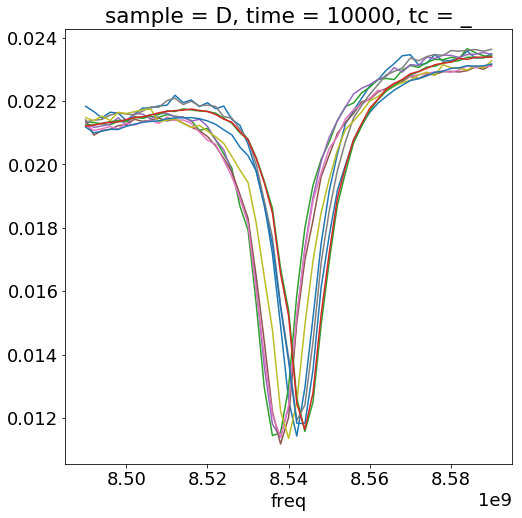

In [12]:
for samp in fps:
    da1 = da_sw.loc[samp].dropna(dim = 'tc', how = 'all').sel(tc = '_')
    for time in da1.indexes['time']:
        da1.sel(time = time).plot()

In [13]:
das = []
das_bv = []

for samp in fps:
    direc = os.path.join(fps[samp],'FreqFluence')
    print('Loading data for ' + samp)
    s_fps = load.freqfluence_flist(direc)
#     print(s_fps)
    s,backvs = load.freqfluence_load(s_fps)
    print('Converting to Dataset')
    da = xr.DataArray.from_series(s)
    da = da.expand_dims('sample')
    da['sample'] = [samp]
    das.append(da)
    
    da_bv = xr.DataArray.from_series(backvs)
    da_bv = da_bv.expand_dims('sample')
    da_bv['sample'] = [samp]
    das_bv.append(da_bv)
    
da_dv = xr.concat(das, dim = 'sample')
da_bv = xr.concat(das_bv,dim = 'sample')

Loading data for C
Converting to Dataset
Loading data for A
Converting to Dataset
Loading data for D
Converting to Dataset


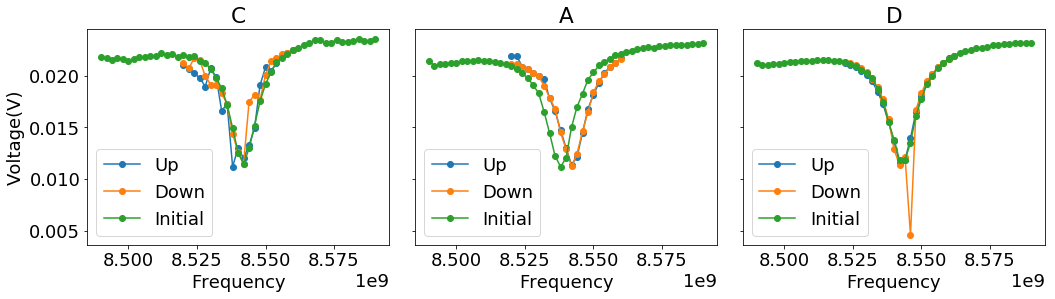

In [14]:
size = len(fps)
fig, axes = plt.subplots(1,size, figsize = (5*size,1.5*size) , sharey = True)

for i, samp in enumerate(fps):
    swp_bv_u = da_bv.sel(sample = samp, direction = 'U').dropna(dim = 'freq')
    axes[i].plot(swp_bv_u.indexes['freq'],swp_bv_u,marker = 'o', label = 'Up')
    swp_bv_d = da_bv.sel(sample = samp, direction = 'D').dropna(dim = 'freq')
    axes[i].plot(swp_bv_d.indexes['freq'],swp_bv_d,marker = 'o', label = 'Down')
    swp_init = da_sw.sel(sample = samp, tc = '_', time = 0)
    axes[i].plot(swp_init.indexes['freq'],swp_init,marker = 'o',label = 'Initial')
    axes[i].set_title(samp)
    axes[i].legend()
    axes[i].set_xlabel('Frequency')
    if i == 0: axes[i].set_ylabel('Voltage(V)') 
fig.tight_layout()

In [15]:
v0s_bv = da_bv.sel(direction = 'U')
v0s_sw = da_sw.sel(tc = '_',time = 0).dropna(dim = 'freq')

# v0_C = da_bv.sel(sample = 'C' , direction = 'D')
v0_C =  da_sw.sel(sample = 'C', tc = '_',time = 0).dropna(dim = 'freq')
v0_A = da_bv.sel(sample = 'A' , direction = 'D')
v0_A = v0_A.fillna(0.02164)
v0_D = da_bv.sel(sample = 'D' , direction = 'U')
v0_D = v0_D.fillna(0.02135)

v0_C_i = da_bv.sel(sample = 'C' , direction = 'D')
v0_C_i.loc[:] = np.interp(v0s_bv.indexes['freq'],v0_C.indexes['freq'],v0_C.values )
# v0_C_i.set_index({'sample': 'C'})

v0s = xr.concat([v0_C_i, v0_A, v0_D], dim = 'sample').drop('direction')
v0s

<xarray.DataArray (sample: 3, freq: 22)>
array([[0.021946, 0.021756, 0.02184 , 0.021423, 0.021231, 0.020638, 0.019791,
        0.018761, 0.017182, 0.014927, 0.012549, 0.01143 , 0.012951, 0.01516 ,
        0.017496, 0.019165, 0.020318, 0.021283, 0.021698, 0.022088, 0.022477,
        0.022665],
       [0.02114 , 0.02108 , 0.02083 , 0.0206  , 0.02021 , 0.01992 , 0.01902 ,
        0.01787 , 0.01673 , 0.01449 , 0.01288 , 0.01123 , 0.01244 , 0.0146  ,
        0.01649 , 0.01838 , 0.01947 , 0.02015 , 0.02083 , 0.02124 , 0.02164 ,
        0.02164 ],
       [0.02135 , 0.02122 , 0.02097 , 0.02081 , 0.02045 , 0.02008 , 0.01944 ,
        0.01845 , 0.0172  , 0.01547 , 0.01367 , 0.0115  , 0.01181 , 0.01394 ,
        0.01651 , 0.01797 , 0.0194  , 0.02012 , 0.02081 , 0.02125 , 0.02165 ,
        0.0219  ]])
Coordinates:
  * freq     (freq) float64 8.52e+09 8.522e+09 8.524e+09 ... 8.56e+09 8.562e+09
  * sample   (sample) <U1 'C' 'A' 'D'

In [16]:
fittype = 'lor'
# fittype = 'poly'

if fittype == 'lor':
    Rinf = 0.02125
    f0 = 8.54e9
    p0 =[f0,1e7,0.01, Rinf]
    p_labels = ['f0','Q','R','Rinf'] 
    epsilon = 0.00001
#     bounds = ([0,0,0, Rinf - epsilon],[np.inf,np.inf,np.inf, Rinf + epsilon])
    bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf])
    window = 100

elif fittype == 'poly':
    window = 2
    p_labels = ['R', 'f0', 'p0','p1','p2']
    bounds = ([-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf])
    p0 = [.01,1e-9,1e-18]
    
    
def fitsweep(v, p0, bounds, window, fittype, p_labels):
    if fittype == 'lor':
        
        xdata = v.indexes['freq']
        ydata = v.values
        v_p, v_sl = analysis.fit_lor(xdata,ydata, p0,bounds, window)
        v_fit = analysis.lorfn(*v_p)

    elif fittype == 'poly':
        
        v_p, v_sl = analysis.fit_poly2(v, p0, bounds , window)
        v_fit = analysis.poly2fn(*v_p)
        minR, minf = analysis.polymin(v, v_sl, v_fit)
        v_p = [minR, minf, *v_p]

    return v_fit, v_p, v_sl

In [17]:
da_p = da_dv.isel(freq = 0).drop('freq').where(False).copy()
da_p0 = da_sw.sel(tc = '_',time = 0).isel(freq = 0).drop('tc').drop('time').drop('freq').where(False).copy()

da_p_dict = {}
da_p0_dict = {}
for p in p_labels:
    da_p_dict[p] = da_p
    da_p0_dict[p] = da_p0
    
#Not exactly sure why I have to do this copying. Otherwise I think the reference to the original numpy array is kept and assignments get all weird
ds_p = xr.Dataset(da_p_dict).copy(deep=True)
ds_p0 = xr.Dataset(da_p0_dict).copy(deep=True)


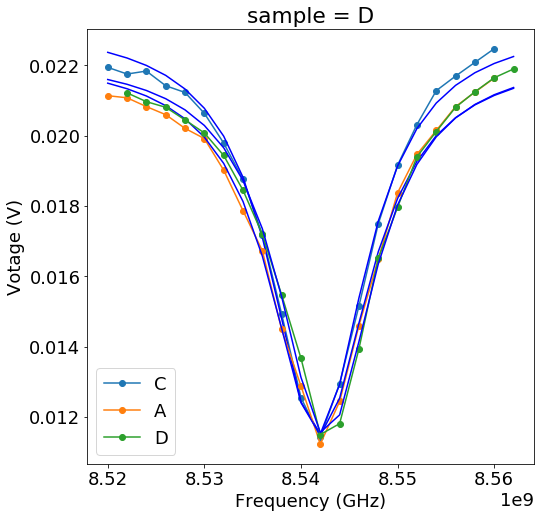

In [18]:
v0_fits = v0s.copy()


samples = v0s.indexes['sample']
freqs_i = da_dv.indexes['freq']
mi = pd.MultiIndex.from_product([samples,freqs_i], names = ['sample', 'freq'])
s = pd.Series(index = mi)
v0s_i = xr.DataArray.from_series(s)


for samp in v0s.indexes['sample']:
    v0 = v0s.loc[samp]
    dv = da_dv.sel(sample = samp, direction = 'U', time = 0).dropna(dim = 'fluence', how = 'all').isel(fluence = -1).dropna(dim = 'freq')
    freqs = dv.indexes['freq']
    
    v0s_i.loc[samp] = v0.interp(freq = freqs).reindex(freq = freqs_i)
    
    v0_fit, v0_p,v0_sl = fitsweep(v0, p0, bounds, window , fittype,p_labels)
    freqs = v0s.indexes['freq'][v0_sl]
    v0_fits.loc[samp] = v0_fit(freqs)
    
    v0s_i.loc[samp].plot(marker = 'o', label = samp)
    v0_fits.loc[samp].plot(color = 'b')
    
    for i, p in enumerate(ds_p0.data_vars):
        ds_p0[p].loc[samp] = v0_p[i]
    
#     K[sample] = analysis.calc_K(f0 = popt[0], w = popt[1], R0 = popt[2], printparams = False)

plt.xlabel('Frequency (GHz)')
plt.ylabel('Votage (V)')
plt.legend()

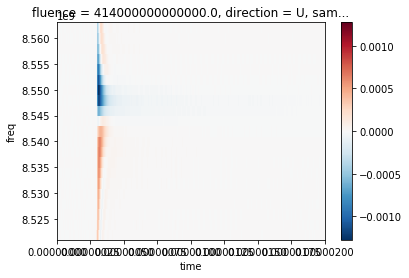

In [20]:
data = da_dv.sel(sample = 'D', direction = 'U').dropna(dim = 'fluence', how = 'all').isel(fluence = -1).dropna(dim = 'freq', how = 'all')
data.plot()

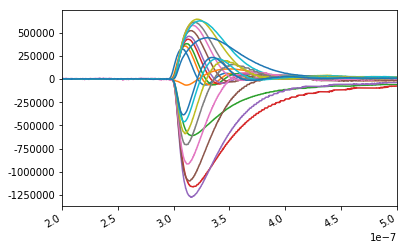

In [18]:
fig, ax = plt.subplots()

freqs = data.indexes['freq']
for freq in freqs:
    trace = data.sel(freq = freq)
    ax.plot(trace.to_series())

expf = exp_formatter(-9)
ax.yaxis.set_major_formatter(FuncFormatter(expf.format_func))

ax.set_xlim(200e-9,500e-9)
fig.autofmt_xdate()

In [96]:
sl = slice(1000,10000,100)
ds_p_r  =  ds_p.sel(direction = 'U').drop(['direction']).copy(deep = True)
dvs = da_dv.sel( direction = 'U').dropna(dim = 'freq', how = 'all').isel(time = sl)

# dvs
vss = v0s - dvs
fits = vss.copy(deep = True)

cds = ds_p_r.coords

for samp in vss.indexes['sample']:
    vs = vss
    vs = vs.sel(sample = samp).dropna('fluence')
    for flu in vs.indexes['fluence']:
        vs = vs.sel(fluence = flu).dropna('time')
        for time in vs.indexes['time']:
            vs = vs.sel(time = time)
            vs_fit, vs_p,vs_sl = fitsweep(vs, p0, bounds, window , fittype,p_labels)

            freqs = vs.indexes['freq'][vs_sl]
            fits.loc[:,samp,flue,time] = vs_fit(freqs).values
            
            
fits.name = 'fits'
dvs.name = 'dvs'
vss.name = 'vss'

            
# das = {'dvs': dvs, 'fits': fits}
das = [dvs,fits,vss]
ds = xr.merge(das)

In [98]:
def vsplotxr(timesel, dvs, vss = None, fits = None, v0 = None, v0_fit = None):
    timesel = timesel *1e-9
    if fits is not None:
        times = fits.indexes['time']
        sample = fits.sample.values
    elif vss is not None:
        times = vss.indexes['time']
        sample = vss.sample.values
    
    timesel = min(times, key=lambda x:abs(x-timesel))

    fig, axes = plt.subplots(2,1, figsize = (7,10), sharex = True)
    axes[0].axhline(0, color = 'gray', linestyle = '--')
    axes[0].plot(dvs.loc[:,timesel].to_series(), marker = 'o')

    if v0 is not None:
        v0 = v0.to_series()
        axes[1].plot(v0, label = 'cavity sweep', marker = 'o')
        axes[1].axvline(v0.idxmin(), color = 'gray', linestyle = '--')
        axes[0].axvline(v0.idxmin(), color = 'gray', linestyle = '--')
    if v0_fit is not None:
        axes[1].plot(v0_fit.to_series(), label = 'cavity sweep fit')
        
    
    if vss is not None:
        axes[1].plot(vss.loc[:,timesel].to_series(), color = 'r', label = 'cavity sweep + deltaV' ,  marker = 'o')
#         print(vss.loc[:,timesel].to_series())
    if fits is not None:
        axes[1].plot(fits.loc[:,timesel].to_series(), label = 'cavity sweep + deltaV fit')
#         print(fits.loc[:,timesel].to_series())

    axes[0].set_ylabel('Delta V (V)')
    axes[1].set_ylabel('$V_r$ (V)')
    axes[1].set_xlabel('Frequency (Hz)')

    # axes[1].set_xlim([8.525e9,8.545e9])
    # axes[1].set_ylim([0.4,0.8])

    fig.suptitle('Delta V taken at ' + str(timesel) + 's for sample ' + str(sample))
    
    return fig, axes

(<Figure size 504x720 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f09d8c3dfd0>,
       dtype=object))

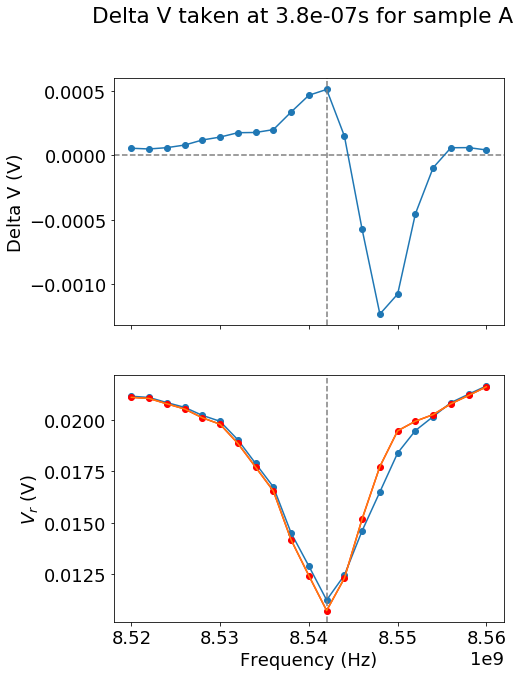

In [101]:
samp = 'A'

dst = ds.sel(sample = samp).dropna('fluence','all').isel(fluence = -1)
v0 = v0s_i.sel(sample = samp)

vsplotxr(380, dst['dvs'], vss= dst['vss'], fits = dst['fits'], v0 = v0_i, v0_fit = None)

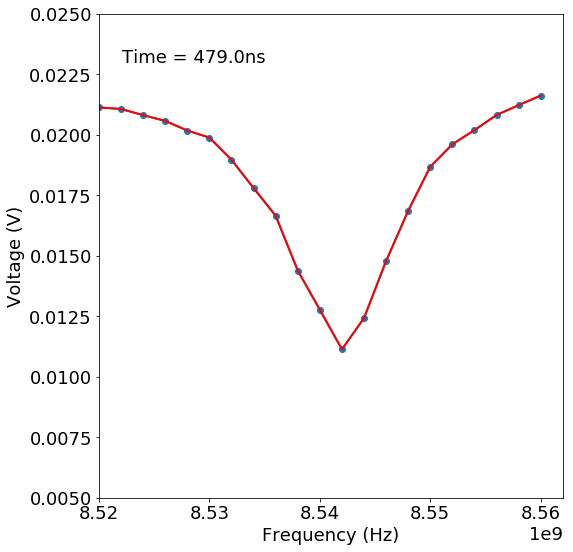

In [100]:
# First set up the figure, the axis, and the plot element we want to animate

timesel1 = 250e-9
timesel2 = 500e-9

fittimes = dst.indexes['time']

idx1 = abs(fittimes - timesel1).argmin()
idx2 = abs(fittimes - timesel2).argmin()

RawData_Frames = dst['vss'].loc[:,fittimes[idx1]:fittimes[idx2]]
RawData_Frames_fit = dst['fits'].loc[:,fittimes[idx1]:fittimes[idx2]]
timeindex = fittimes[idx1:idx2]
interval = 50
xs = dst.indexes['freq']

fig = plt.figure()
ax = plt.axes(xlim=(xs[0], xs[-1]), ylim = (0.005,0.025))

line, = ax.plot([], [], lw=2, marker = 'o')
line_fit, = ax.plot([], [], lw=2, color = 'r')

time_template = 'Time = %.1fns'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

fig.tight_layout()

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line_fit.set_data([], [])
    time_text.set_text('')
    ax.set_ylabel("Voltage (V)")
    ax.set_xlabel("Frequency (Hz)") 
    return line,line_fit

# animation function.  This is called sequentially
def animate(i):
    line.set_data(xs, RawData_Frames.loc[:,timeindex[i]])
    line_fit.set_data(xs, RawData_Frames_fit.loc[:,timeindex[i]])
    time_text.set_text(time_template % int(timeindex[i]*1e9))
    return line, time_text



# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(timeindex), interval = interval, blit=True)


# TML(anim.to_html5_video())

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

anim

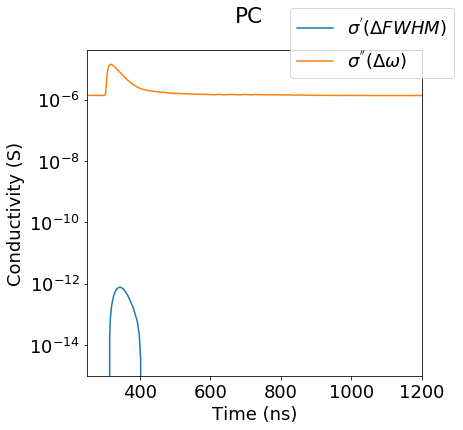

In [98]:
fig, axes = plt.subplots(1,1, figsize = (6,6), sharex = True)

e0 = 8.854e-12
F=1

deltaf = ds_p_r['f0']- ds_p0['f0'].loc[samp]
deltaf = abs(deltaf)
sig_I = 2*deltaf*e0/F

# deltaR = params['R']- v0_p['R']
# sig_R = (1/K['KCs'])*(deltaR/v0_p['R'])
# sig_R = abs(sig_R)
# label = '$\sigma^{\'}(\Delta R)$'

deltaFWHM = ds_p0['Q'].loc[samp]*((1/ds_p_r['Q'])- (1/ds_p0['Q'].loc[samp]))  
sig_R = deltaFWHM*e0/F
label = '$\sigma^{\'}(\Delta FWHM)$'
    

axes.plot(sig_R.to_series(), label = label)
axes.set_yscale('log')
axes.set_ylabel('Conductivity (S)')

axes.plot(sig_I.to_series(), label = '$\sigma^{\'\'}(\Delta\omega)$')
axes.set_yscale('log')
axes.set_ylabel('Conductivity (S)')

axes.set_xlim(250e-9,1200e-9)

fmt = exp_formatter(-9)
axes.xaxis.set_major_formatter(FuncFormatter(fmt.format_func))
axes.set_xlabel('Time (ns)')
# for ax in axes:
# axes.set_ylim([1e-8,1e-4])
fig.suptitle(samp)
fig.legend()

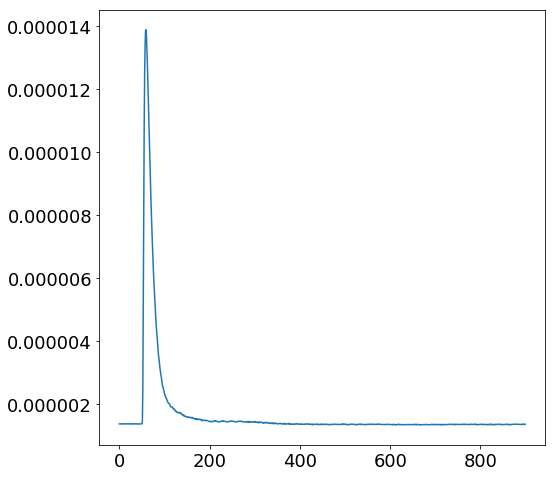

In [99]:
# plt.plot(ds_p_r['Q'])
# plt.plot(deltaf)
plt.plot(sig_I)
# plt.yscale('log')